In [ ]:
!pip install -q --upgrade pip
!pip install -U jaxlib==0.4.4+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.2+cuda11.cudnn82
    Uninstalling jaxlib-0.4.2+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.4.2+cuda11.cudnn82


  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK

/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK


In [3]:
from network_config import get_network_configuration
from train import cross_validate, cross_entropy

from jax import numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, grad, vmap

import numpy as np
import os
import pandas as pd

In [6]:
# load preprocessed data

dataset_name = "MUTAG"
base_path = f"/content/drive/MyDrive/MasterarbeitData/Preprocessed/{dataset_name}"

ys = jnp.load(base_path + f"/ys.npy")
graphs_edge_features = jnp.load(base_path + f"/graphs_edge_features.npy")
graph_two_wl_pattern = jnp.load(base_path + f"/two_wl_pattern_radius_1.npy")

# batch x #nodes x 1 x #channels ?
print(graphs_edge_features.shape)
print(graph_two_wl_pattern.shape)

(188, 28, 28, 8)
(376, 4)


In [7]:
# load the network configuration
dataset = "MUTAG"
method = "twl"
configuration = "gd"

init_fn, apply_fn, kernel_fn = get_network_configuration(dataset, method, configuration)


# loss function
loss = jit(cross_entropy)
grad_loss = jit(grad(lambda params, x, y, pattern: loss(y, apply_fn(params, x, pattern=pattern))))

In [8]:
cv_folds = 10
learning_rate =  0.0005
epochs = 200
nn_type = "twl"

train_losses_cv_runs, val_losses_cv_runs, train_acc_cv_runs, val_acc_cv_runs = cross_validate(
    graphs_edge_features,
    ys,
    graph_two_wl_pattern,
    cv_folds,
    init_fn,
    apply_fn,
    learning_rate,
    epochs,
    nn_type,
    loss,
    grad_loss)

Start CV fold: 0
nb train samples: 152 | nb val samples: 38
	 train loss: 108.01 | val loss: 117.47 | train acc: 0.3487 | val acc: 0.2895
	 train loss: 49.42 | val loss: 53.94 | train acc: 0.3487 | val acc: 0.2895
	 train loss: 5.49 | val loss: 4.47 | train acc: 0.6513 | val acc: 0.7105
	 train loss: 8.13 | val loss: 6.67 | train acc: 0.6513 | val acc: 0.7105
	 train loss: 3.80 | val loss: 4.29 | train acc: 0.3487 | val acc: 0.2895
	 train loss: 2.03 | val loss: 1.63 | train acc: 0.6513 | val acc: 0.7105
	 train loss: 0.84 | val loss: 0.68 | train acc: 0.6513 | val acc: 0.7105
	 train loss: 0.63 | val loss: 0.63 | train acc: 0.6645 | val acc: 0.7368
	 train loss: 0.63 | val loss: 0.63 | train acc: 0.6711 | val acc: 0.7632
	 train loss: 0.61 | val loss: 0.59 | train acc: 0.6513 | val acc: 0.7105
Start CV fold: 1
nb train samples: 152 | nb val samples: 38
	 train loss: 111.31 | val loss: 104.41 | train acc: 0.3289 | val acc: 0.3684
	 train loss: 50.89 | val loss: 47.90 | train acc: 0.328

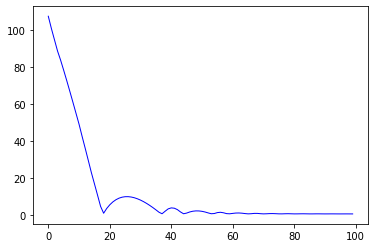

In [6]:
plt.plot(jnp.array(range(epochs)), jnp.array(train_losses_cv_runs[0]), 'b-', linewidth=1)

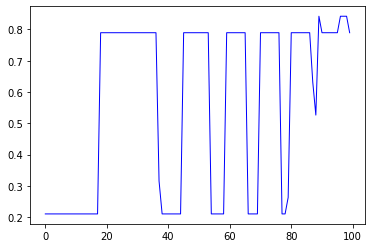

In [8]:
plt.plot(jnp.array(range(epochs)), jnp.array(val_acc_cv_runs[0]), 'b-', linewidth=1)

In [13]:
# prepare results and save them

train_losses_cv_runs_array = np.array([np.array(i) for i in train_losses_cv_runs])
val_losses_cv_runs_array = np.array([np.array(i) for i in val_losses_cv_runs])
train_acc_cv_runs_array = np.array([np.array(i) for i in train_acc_cv_runs])
val_acc_cv_runs_array = np.array([np.array(i) for i in val_acc_cv_runs])

# save the raw data
dataset = "MUTAG"
training_method = "Gradient_Descent"

repo_path = "/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK"
results_path = repo_path + f"/Results/{dataset}/{training_method}" 
if not os.path.exists(results_path):
    os.makedirs(results_path)

np.save(results_path + f"/train_losses_CV_folds_{cv_folds}_epochs_{epochs}.npy", train_losses_cv_runs_array)
np.save(results_path + f"/val_losses_CV_folds_{cv_folds}_epochs_{epochs}.npy", val_losses_cv_runs_array)
np.save(results_path + f"/train_acc_CV_folds_{cv_folds}_epochs_{epochs}.npy", train_acc_cv_runs_array)
np.save(results_path + f"/val_acc_CV_folds_{cv_folds}_epochs_{epochs}.npy", val_acc_cv_runs_array)

# use for each cv run the epoch with the highest validation acc
max_acc_for_cv_folds = np.amax(val_acc_cv_runs_array, 1)
mean = np.mean(max_acc_for_cv_folds)
std = np.std(max_acc_for_cv_folds)
min, q_25, q_50, q_75, max = tuple(np.quantile(max_acc_for_cv_folds, [0, 0.25, 0.5, 0.75, 1.0]))

print("mean:", mean)
print("std:", std)
print("min:", min)
print("q_25:", q_25)
print("q_50:", q_50)
print("q_75:", q_75)
print("max:", max)

# append the reults of the run to the results csv
result_csv_path = repo_path + "/Results/results.csv"
result_table_append = pd.DataFrame([[pd.Timestamp.utcnow(), dataset, training_method, cv_folds, "accuracy",
               mean, std, min, q_25, q_50, q_75, max]], 
             columns = ["UTC Time", "Dataset", "Training Method", " Nb CV folds", 
                        "Metric", "mean", "std", "min", "q_25", "q_50", "q_75", "max"])

result_table = pd.read_csv(result_csv_path)
result_table.append(result_table_append).to_csv(result_csv_path, index = False)
